# Advanced-эксперименты с библиотекой DepGraph

[Ссылка](https://github.com/VainF/Torch-Pruning/) на репозиторий библиотеки.

### Импорт модулей

In [1]:
!pip install torch-pruning torcheval --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from torch import nn
from torch.fx import symbolic_trace
import torch.utils.data
import torchvision
from torchvision import transforms
from torcheval.metrics import BinaryAUROC

from torchvision.models import resnet50
import torch_pruning as tp

import numpy as np
from scipy.stats import spearmanr, kendalltau

import abc
from typing import Any, Callable, Dict, List, Optional, Tuple, Set
from functools import reduce, partial
import re
import copy
import collections
from collections import defaultdict
from __future__ import annotations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import networkx as nx

sns.set_style('darkgrid')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### Реализации модулей и функций

Данные.

In [3]:
def get_dataloaders(classes: List[int], batch_size: int = 16, img_size: int = 33, need_val: bool = False, cifar100: bool = False, train_limit = None):
    classes_to_ids = {cls : i for i, cls in enumerate(classes)}
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if cifar100:
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
        
    trainset = [(x, classes_to_ids[y]) for x, y in trainset if y in classes]
    if need_val:
        _trainset = trainset[:len(trainset)//2]
        valset  = trainset[len(trainset)//2:]
        trainset = _trainset
    if train_limit:
        trainset = trainset[:train_limit]
        
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    if need_val:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True)
    if cifar100:
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    else:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    testset = [(x, classes_to_ids[y]) for x, y in testset if y in classes]
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)
    if need_val:
        return trainloader, valloader, testloader
    return trainloader, testloader

Циклы обучения и теста.

In [4]:
def train_loop(model, traindata, testdata, epoch_num=1, lr=1e-3, device='cuda'):
    history = []
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    batch_seen = 0
    
    for epoch_num in range(epoch_num):
        losses = []
        tq = tqdm(traindata, leave=False)
        
        for x, y in tq:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            
            if not isinstance(out, torch.Tensor):
                out = out[0] #  when features are also returned in forward
            
            loss = criterion(out, y)
            loss.backward()
            optim.step()
            losses.append(loss.cpu().detach().numpy())
            
            batch_seen += 1
            metric_result = test_loop(model, testdata, device)
            tq.set_description(f'Epoch: {epoch_num}, Loss: {str(np.mean(losses))}, ROC-AUC: {metric_result}')
            history.append(metric_result)
                
    return history

def test_loop(model, testdata, device='cuda', return_loss=False):
    criterion = torch.nn.CrossEntropyLoss()
    metric = BinaryAUROC(device=device)
    model.to(device)
    model.eval()
    loss = 0.0

    for x, y in testdata:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        if not isinstance(out, torch.Tensor):
            out = out[0] #  when features are also returned in forward
        pred = out.argmax(-1)
        metric.update(pred, y)
        if return_loss:
            loss += criterion(out, y).detach().cpu().item()
    
    metric_result = metric.compute().item()
    
    model.train()
    if return_loss:
        return loss
    
    return metric_result

Напишем функцию для создания полной модели.

In [ ]:
def get_model(device='cuda'):
    trainloader, testloader = get_dataloaders([8,9], batch_size=64)
    full_model = resnet50(pretrained=True)
    full_model.fc = torch.nn.Linear(full_model.fc.in_features, 2)
    train_loop(full_model, trainloader, testloader)
    full_model = full_model.to(device)

    return full_model

Реализация графовой модели.

In [ ]:
class GraphEdge:
    """
    Edge between source_module and target_module.
    gamma: weight of information flow (0..1)
    dep: original tp.dependency.Dependency object (optional)
    """
    def __init__(self, source: nn.Module, target: nn.Module, dep: Optional[Any] = None, gamma: float = 0.0):
        self.source = source
        self.target = target
        self.dep = dep
        self.gamma = float(gamma)

    def __repr__(self):
        s_name = str(self.source)
        t_name = str(self.target)
        return f"GraphEdge({s_name} -> {t_name}, gamma={self.gamma:.4f})"
    
    def __eq__(self, other):
        if not isinstance(other, GraphEdge):
            return False
        return (
            self.source is other.source and 
            self.target is other.target and 
            self.gamma == other.gamma
        )
    
    def __hash__(self):
        s_name = str(self.source)
        t_name = str(self.target)
        return hash(f"GraphEdge({s_name} -> {t_name}")


class GraphNode:
    """
    The node of the graph corresponds to a module.
    Stores a reference to the module, incoming and outgoing edges.
    """
    def __init__(self, module: nn.Module):
        self.module = module
        self.in_edges: List[GraphEdge] = []
        self.out_edges: List[GraphEdge] = []
        self.level: Optional[int] = None  # for the topological level

    def __repr__(self):
        return f"GraphNode({str(self.module)}, level={self.level}, in={len(self.in_edges)}, out={len(self.out_edges)})"


class GraphModel:
    """
    A GraphModel is created from a PyTorch model using tp.DependencyGraph.

    Args:
        model: nn.Module, pytorch model.
        example_inputs: example input tensor for tp.DependencyGraph.build_dependency.
        weight_init: 'uniform'|'by_params'|'custom'
        custom_weight_fn: Optional[Callable[[GraphEdge], float]] if weight_init == 'custom'.
        normalize_by_level: normalizes the total weight of the edges at each level to 1.0 if True.
    """
    def __init__(
        self,
        model: nn.Module,
        example_inputs: torch.Tensor,
        weight_init: str = "uniform",
        custom_weight_fn: Optional[Callable[[GraphEdge], float]] = None,
        normalize_by_level: bool = True,
    ):
        self.model = model
        self.example_inputs = example_inputs
        self.DG: tp.dependency.DependencyGraph = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
        # node_map: nn.Module -> GraphNode
        self.node_map: Dict[nn.Module, GraphNode] = {}
        # edges list
        self.edges: Set[GraphEdge] = set()

        # build graph nodes from DG.module2node keys
        for module in list(self.DG.module2node.keys()):

            # TODO ====================================
            # if 'torch_pruning.ops' in str(type(module)):
            #     continue
            # =========================================

            self.node_map[module] = GraphNode(module)

        # build GraphEdges from dependencies in DepGraph
        # iterate all nodes and their dependencies
        for module, node in self.DG.module2node.items():
            
            # TODO ====================================
            # if module not in self.node_map:
            #     continue
            # =========================================

            for node_in in node.inputs:
                # create edge
                edge = GraphEdge(source=node_in.module, target=module, gamma=0.0)
                self.edges.add(edge)
                # attach to node_map if present
                self.node_map[module].in_edges.append(edge)
                """
                if node_in.module in self.node_map:
                    self.node_map[node_in.module].out_edges.append(edge)
                if module in self.node_map:
                    self.node_map[module].in_edges.append(edge)
                """
            for node_out in node.outputs:
                # create edge
                edge = GraphEdge(source=module, target=node_out.module, gamma=0.0)
                self.edges.add(edge)
                # attach to node_map if present
                self.node_map[module].out_edges.append(edge)
                """
                if node_out.module in self.node_map:
                    self.node_map[node_out.module].out_edges.append(edge)
                if module in self.node_map:
                    self.node_map[module].in_edges.append(edge)
                """
            """
            for dep in getattr(node, "dependencies", []) or []:
                src_mod = dep.source.module
                tgt_mod = dep.target.module
                # create edge
                edge = GraphEdge(source=src_mod, target=tgt_mod, dep=dep, gamma=0.0)
                self.edges.append(edge)
                # attach to node_map if present
                if src_mod in self.node_map:
                    self.node_map[src_mod].out_edges.append(edge)
                if tgt_mod in self.node_map:
                    self.node_map[tgt_mod].in_edges.append(edge)
            """
        # compute node levels (topological layering)
        self._assign_levels()

        # initialize raw weights
        if weight_init == "uniform":
            self._init_weights_uniform()
        elif weight_init == "by_params":
            self._init_weights_by_params()
        elif weight_init == "custom":
            if custom_weight_fn is None:
                raise ValueError("custom_weight_fn must be provided when weight_init=='custom'")
            self._init_weights_custom(custom_weight_fn)
        else:
            raise ValueError(f"Unknown weight_init: {weight_init}")

        # normalize by level, sum weights of edges at each level equals 1
        if normalize_by_level:
            self.normalize_levelwise()

    def _assign_levels(self):
        """
        Assign a level to each node (distance from inputs).
        Approach: find nodes with empty inputs (sources), group with BFS.
        If it is a cycle, we use the topological order DG (DepGraph is usually acyclic).
        """
        # nodes set
        nodes = list(self.node_map.values())
        # input nodes, in_edges==0
        input_nodes = [n for n in nodes if len(n.in_edges) == 0]
        
        if not input_nodes:
            min_in = min(len(n.in_edges) for n in nodes)
            input_nodes = [n for n in nodes if len(n.in_edges) == min_in]

        # BFS
        queue = collections.deque()
        for n in input_nodes:
            n.level = 0
            queue.append(n)

        visited = set(input_nodes)
        while queue:
            cur = queue.popleft()
            for e in cur.out_edges:
                nxt = self.node_map.get(e.target, None)
                if nxt is None:
                    # e.target may be a module not present in map (rare) — try to find by identity
                    nxt = self.node_map.get(e.target, None)
                if nxt is None:
                    continue
                # level is max(level, cur.level+1)
                new_level = (cur.level or 0) + 1
                if nxt.level is None or new_level > nxt.level:
                    nxt.level = new_level
                if nxt not in visited:
                    visited.add(nxt)
                    queue.append(nxt)

        # For any node still None (disconnected components), assign increasing levels
        max_level = max((n.level for n in nodes if n.level is not None), default=0)
        for n in nodes:
            if n.level is None:
                max_level += 1
                n.level = max_level

    def _init_weights_uniform(self):
        for e in self.edges:
            e.gamma = 1.0  # temporary - normalized per-level later

    def _init_weights_by_params(self):
        """
        Initialization of the weight is proportional to the number of output channels (if any),
        otherwise by the number of source module parameters, otherwise 1.  
        """
        def out_channels_of_module(m: nn.Module) -> Optional[int]:
            if hasattr(m, "out_channels"):
                return getattr(m, "out_channels")
            if hasattr(m, "num_features"):
                return getattr(m, "num_features")
            return None

        for e in self.edges:
            src = e.source
            oc = out_channels_of_module(src)
            if oc is not None:
                e.gamma = float(max(1, oc))
            else:
                # fallback to param count (scaled)
                pcount = sum(p.numel() for p in src.parameters() if p.requires_grad)
                e.gamma = float(max(1.0, pcount / 1e3))

    def _init_weights_custom(self, fn: Callable[[GraphEdge], float]):
        for e in self.edges:
            val = float(fn(e))
            e.gamma = max(0.0, val)

    def normalize_levelwise(self):
        """
        For each level, the total weight of the edges (all edges whose source.node has a given level)
        reduce it so that the sum = 1.0 (or if the sum==0, we distribute it uniform).
        """
        for node in self.node_map.values():
            outs = node.out_edges
            k = len(outs)
            if k > 0:
                per = 1.0 / k
                for e in outs:
                    e.gamma = per


    def normalize_levelwise_old(self):
        """
        For each level, the total weight of the edges (all edges whose source.node has a given level)
        reduce it so that the sum = 1.0 (or if the sum==0, we distribute it uniform).
        """
        # grouping edges by level source
        edges_by_level: Dict[int, List[GraphEdge]] = {}
        for e in self.edges:
            src_node = self.node_map.get(e.source, None)
            level = src_node.level if src_node is not None else 0
            edges_by_level.setdefault(level, []).append(e)

        for level, edges in edges_by_level.items():
            s = sum(e.gamma for e in edges)
            if s <= 0:
                # uniforn
                per = 1.0 / len(edges)
                for e in edges:
                    e.gamma = per
            else:
                # normilize
                for e in edges:
                    e.gamma = e.gamma / s

    def get_edges(self) -> List[GraphEdge]:
        return list(self.edges)

    def get_nodes(self) -> List[GraphNode]:
        return list(self.node_map.values())

    def forward_with_flow(
            self,
            x: torch.Tensor,
            mask: Optional[Dict[GraphEdge, int]] = None,
            return_activations: bool = False
            ):
        """
        Call a forward of the original model and estimate how much of the information passes through which edges.
        Remark: This is an estimate based on a pre-assigned gamma. It does NOT replace the real balance of activations,
        but it provides a structure for decision-making in structural pruning.

        Returns:
            output, flow_map, (activations if return_activations=True)
        where flow_map: Dict[GraphEdge, float] — the information through edge
        """
        # first full forward-pass. Save intermediate activations via forward hooks for modules in node_map.
        activations: Dict[nn.Module, torch.Tensor] = {}

        hooks = []
        def make_hook(m):
            def hook(_, inp, out):
                # save only tensor (of tuple[0])
                activations[m] = out.detach() if isinstance(out, torch.Tensor) else (out[0].detach() if isinstance(out, (list, tuple)) and len(out)>0 else out)
            return hook

        for mod in self.node_map.keys():
            try:
                h = mod.register_forward_hook(make_hook(mod))
                hooks.append(h)
            except Exception:
                # if not support hook
                pass

        out = self.model(x)

        # remove hooks
        for h in hooks:
            h.remove()

        # calculation of the flow
        # flow_in(node) = sum incoming edge.gamma
        # flow_on_edge = edge.gamma * norm_of_source_activation (1.0 if there is no activation)
        flow_map: Dict[GraphEdge, float] = {}
        for e in self.edges:
            src = e.source
            act = activations.get(src, None)
            # estimate value as L1-norm
            if isinstance(act, torch.Tensor):
                approx_size = float(torch.abs(act).sum().cpu().item())
            else:
                approx_size = 1.0
            flow_map[e] = e.gamma * approx_size

            # apply a mask
            if mask is not None:
                flow_map[e] *= mask[e]


        # normilize flow_map
        total = sum(flow_map.values())
        if total > 0:
            for e in list(flow_map.keys()):
                flow_map[e] = flow_map[e] / total
        else:
            # if zero, distribute by levels uniform
            ne = len(flow_map)
            if ne > 0:
                for e in list(flow_map.keys()):
                    flow_map[e] = 1.0 / ne

        if return_activations:
            return out, flow_map, activations
        return out, flow_map

    def get_pruning_group_for(self, module: nn.Module, pruning_fn: Callable, idxs: List[int]):
        """
        Wrapper for `DG.get_pruning_group`
        """
        return self.DG.get_pruning_group(module, pruning_fn=pruning_fn, idxs=idxs)

    def print_summary(self, max_edges: int = 200):
        print("GraphModel summary")
        print(f" Modules: {len(self.node_map)}; Edges: {len(self.edges)}")
        levels = collections.defaultdict(list)
        for n in self.node_map.values():
            levels[n.level].append(n)
        print(" Levels:", {k: len(v) for k, v in levels.items()})
        print(" Sample edges (up to max):")
        for i, e in enumerate(self.edges):
            if i >= max_edges: break
            src_name = str(e.source)
            tgt_name = str(e.target)
            print(f"  - {src_name} -> {tgt_name} | gamma={e.gamma:.4f}")

Функция для визуализации графа.

In [ ]:
def graphmodel_to_networkx(gm):
    """
    Преобразует наш GraphModel в networkx.DiGraph.
    Узлы: имена модулей (или id(module)).
    Рёбра: (source → target) с атрибутом weight=gamma.
    """
    G = nx.DiGraph()

    # Добавляем узлы
    for node in gm.get_nodes():
        mod = node.module
        G.add_node(
            id(mod),
            #label=mod.__class__.__name__,
            label=str(mod),
            level=node.level
        )

    # Добавляем рёбра
    for e in gm.get_edges():
        src = id(e.source)
        tgt = id(e.target)
        G.add_edge(src, tgt, weight=e.gamma, label=f"{e.gamma:.3f}")

    return G

def level_layout(G):
    levels = {}
    for n, d in G.nodes(data=True):
        lv = d.get("level", 0)
        levels.setdefault(lv, []).append(n)

    pos = {}
    for lv, nodes in levels.items():
        for i, n in enumerate(nodes):
            pos[n] = (i, -lv)   # x=i, y=-level
    return pos


def plot_graph(G, figsize=(12, 8), by_level=False):
    """
    Рисует networkx-граф
    """
    plt.figure(figsize=figsize)

    # Layout
    if not by_level:
        try:
            pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
        except Exception:
            # fallback — spring layout
            pos = nx.spring_layout(G, seed=42)
    else:
        pos = level_layout(G)

    # Узлы
    node_labels = {n: G.nodes[n].get("label", str(n)) for n in G.nodes()}
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color="#ddeeff")
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    # Рёбра
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowsize=15)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.axis("off")
    plt.tight_layout()
    plt.show()


Функция для оптимизации графа.

In [ ]:
def optimize_graph(graph_model, x, surrogate_model_class, n_samples=2000, p=0.5):
    edges = graph_model.get_edges()
    n_edges = len(edges)
    min_flow_delta = torch.inf
    best_mask = None

    # init surrogate model and optimizer
    surrogate_model = surrogate_model_class(n_edges).float()
    optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=1e-3)

    # calculate flow of full model
    _, flow_full = graph_model.forward_with_flow(x)

    for it in tqdm(range(n_samples), desc='sample'):
        # sample mask
        mask_values = torch.randint(0, 2, size=(n_edges,), dtype=torch.float32)
        mask = dict(zip(edges, mask_values))

        # compute flow with this mask
        _, flow_masked = graph_model.forward_with_flow(x, mask=mask)

        # calculate delta flow
        flow_full_values = torch.tensor(list(flow_full.values()))
        flow_masked_values = torch.tensor(list(flow_masked.values()))
        flow_delta = torch.linalg.norm(flow_masked_values - flow_full_values)
        if flow_delta < min_flow_delta:
            best_mask = mask
            min_flow_delta = flow_delta

        # 4. predict loss and optimize
        pred = surrogate_model(mask_values)
        loss = (pred - flow_delta) ** 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 200 == 0:
            print(f"iter {it}\tpred={pred.item():.4f}\ttrue={flow_delta.item():.4f}")

    return surrogate_model, best_mask, min_flow_delta

### Создание графа

Инициализируем модель.

In [6]:
model = get_model(device='cpu')

100%|██████████| 170M/170M [00:01<00:00, 91.3MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


  0%|          | 0/157 [00:00<?, ?it/s]

**Из документации**

Dependency Graph (DepGraph) is the core feature of Torch-Pruning, which provides an automatic mechanism to group dependent layers. There are two key concepts for DepGraph:

- `tp.dependency.Dependency`: the dependency between layers.
- `tp.dependency.DependencyGraph`: A relational graph to model the dependency.
- `tp.dependency.Group`: A list of dependencies that represents the minimally-removable units.

Построим DependencyGraph.

In [7]:
DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224))

У него есть ноды.

In [29]:
nodes = list(DG.module2node.values())

In [33]:
nodes[3].inputs

[<Node: (_ElementWiseOp_3(ReluBackward0))>]

In [37]:
nodes[10].outputs

[<Node: (_ElementWiseOp_6(AddBackward0))>,
 <Node: (layer4.1.conv1 (Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)))>]

У его есть Dependency (Edge of DepGraph).

For the dependency A -> B, the pruning operation ``trigger(A)`` will trigger 
the pruning operation ``handler(B)``.

In [42]:
nodes[2].dependencies

[prune_out_channels on _ElementWiseOp_1(TBackward0) => prune_in_channels on fc (Linear(in_features=2048, out_features=2, bias=True))]

У этого объекта есть такие атрибуты.

In [43]:
nodes[2].dependencies[0].source

<Node: (_ElementWiseOp_1(TBackward0))>

In [44]:
nodes[2].dependencies[0].target

<Node: (fc (Linear(in_features=2048, out_features=2, bias=True)))>

In [51]:
nodes[2].dependencies[0].trigger

<bound method DummyPruner.prune_out_channels of <torch_pruning.ops.ElementWisePruner object at 0x7f24ad334b10>>

Dependency складываются в Group для прунинга.

Group is the basic unit for pruning. It contains a list of dependencies and their corresponding indices.

    group := [ (Dep1, Indices1), (Dep2, Indices2), ..., (DepK, IndicesK) ]

Example: 

For a simple network Conv2d(2, 4) -> BN(4) -> Relu, we have:

    group1 := [ (Conv2d -> BN, [0, 1, 2, 3]), (BN -> Relu, [0, 1, 2, 3]) ]

There are 4 prunable elements, i.e., 4 channels in Conv2d.

The indices do not need to be full and can be a subset of the prunable elements.
For instance, if we want to prune the first 2 channels, we have:

    group2 := [ (Conv2d -> BN, [0, 1]), (BN -> Relu, [0, 1]) ]

When combined with tp.importance, we can compute the importance of corresponding channels.

    imp_1 = importance(group1) # len(imp_1)=4
    imp_2 = importance(group2) # len(imp_2)=2

For importance estimation, we should craft a group with full indices just like group1.
For pruning, we need to craft a new group with the to-be-pruned indices like group2.

Можно доставать Dependency из модуля, например.

In [54]:
group = DG.get_pruning_group(model.layer1[0].conv1, pruning_fn=tp.prune_conv_out_channels, idxs=[2, 6, 9])

In [55]:
for i, (dep, idxs) in enumerate(group):
    trigger = dep.trigger
    handler = dep.handler
    source_layer = dep.source.module
    target_layer = dep.target.module

    print("For Dep: ", dep)
    print(" > Trigger: ", trigger)
    print(" > Handler: ", handler)
    print(" > Source Layer: ", source_layer)
    print(" > Target Layer: ", target_layer)
    print("")

For Dep:  prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)) => prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False))
 > Trigger:  <bound method ConvPruner.prune_out_channels of <torch_pruning.pruner.function.ConvPruner object at 0x7f24c5c1d550>>
 > Handler:  <bound method ConvPruner.prune_out_channels of <torch_pruning.pruner.function.ConvPruner object at 0x7f24c5c1d550>>
 > Source Layer:  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
 > Target Layer:  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

For Dep:  prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)) => prune_out_channels on layer1.0.bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
 > Trigger:  <bound method ConvPruner.prune_out_channels of <torch_pruning.pruner.function.ConvPruner object at 0x7f24c5c1d550>>
 > Han

### Работа с графовой моделью

#### FCN

Создадим модель.

In [37]:
model_fcn = nn.Sequential(
    nn.Linear(10, 64),
    nn.Linear(64, 32),
)

Построим граф.

In [38]:
example_inputs = torch.randn(1, 10)
gm = GraphModel(
    model_fcn,
    example_inputs,
    weight_init='by_params',
    normalize_by_level=True
    )

Визуализируем.

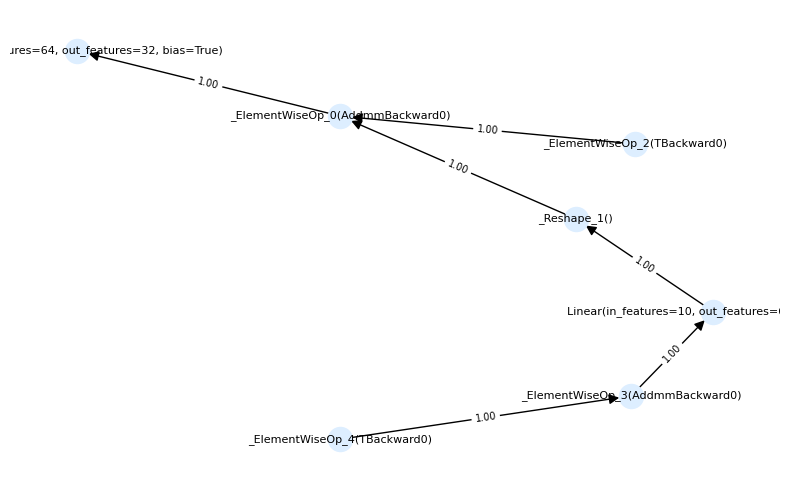

In [39]:
G = graphmodel_to_networkx(gm)
plot_graph(G, figsize=(8, 5))

Добавим нелинейность.

In [40]:
model_fcn = nn.Sequential(
    nn.Linear(10, 64),
    nn.ReLU(),
    nn.Linear(64, 32)
)

Построим граф.

In [41]:
example_inputs = torch.randn(1, 10)
gm = GraphModel(
    model_fcn,
    example_inputs,
    weight_init='by_params',
    normalize_by_level=True
    )

Визуализируем.

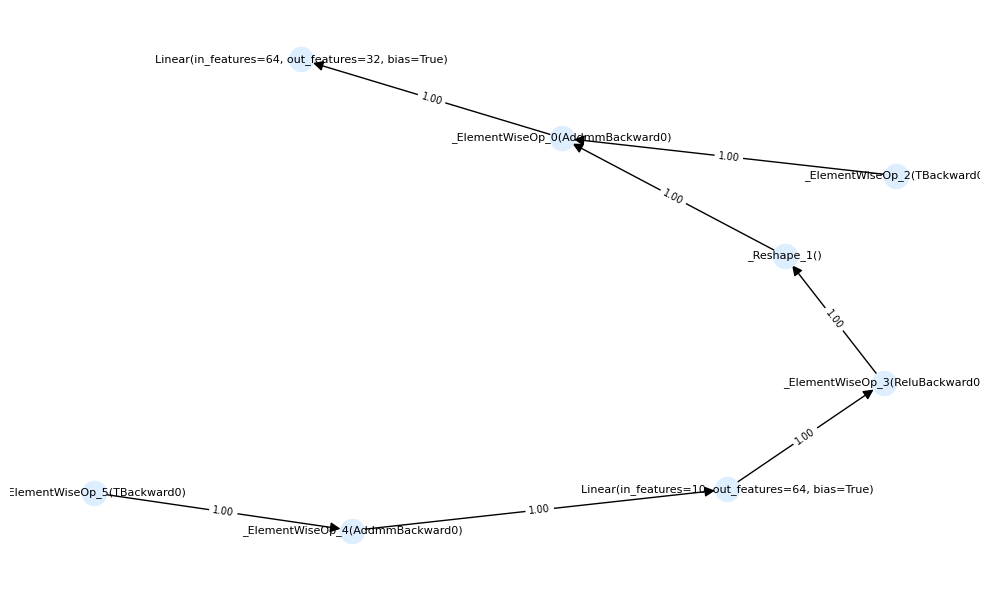

In [42]:
G = graphmodel_to_networkx(gm)
plot_graph(G, figsize=(10, 6))

#### ResNet

Инициализируем модель.

In [14]:
model = get_model(device='cuda')

100%|██████████| 170M/170M [00:02<00:00, 79.3MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s] 


  0%|          | 0/157 [00:00<?, ?it/s]

Создадим графовую модель.

In [15]:
example_inputs = torch.randn(1, 3, 224, 224).to('cuda')
gm = GraphModel(
    model,
    example_inputs,
    weight_init='by_params',
    normalize_by_level=True
    )

In [16]:
gm.print_summary()

GraphModel summary
 Modules: 176; Edges: 191
 Levels: {46: 3, 45: 3, 0: 2, 44: 4, 43: 4, 50: 1, 49: 1, 41: 4, 48: 2, 47: 2, 39: 4, 37: 5, 36: 6, 35: 5, 42: 4, 33: 5, 40: 4, 31: 4, 38: 4, 29: 4, 27: 4, 34: 5, 25: 4, 30: 4, 23: 5, 22: 5, 21: 4, 28: 4, 19: 4, 26: 4, 17: 4, 24: 4, 15: 4, 20: 4, 13: 4, 12: 5, 11: 4, 18: 4, 9: 3, 16: 4, 7: 2, 5: 2, 4: 2, 3: 1, 2: 1, 1: 1, 10: 3, 8: 2, 6: 1, 14: 3, 32: 4}
 Sample edges (up to max):
  - _ElementWiseOp_37(ReluBackward0) -> Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) | gamma=1.0000
  - _ElementWiseOp_24(AddBackward0) -> _ElementWiseOp_23(ReluBackward0) | gamma=1.0000
  - BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) -> _ElementWiseOp_39(ReluBackward0) | gamma=64.0000
  - Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) -> BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) | gamma=64.0000
  - Conv2d(512, 128, kernel_size=(1, 1), stride=(1

Посмотрим на визуализацию.

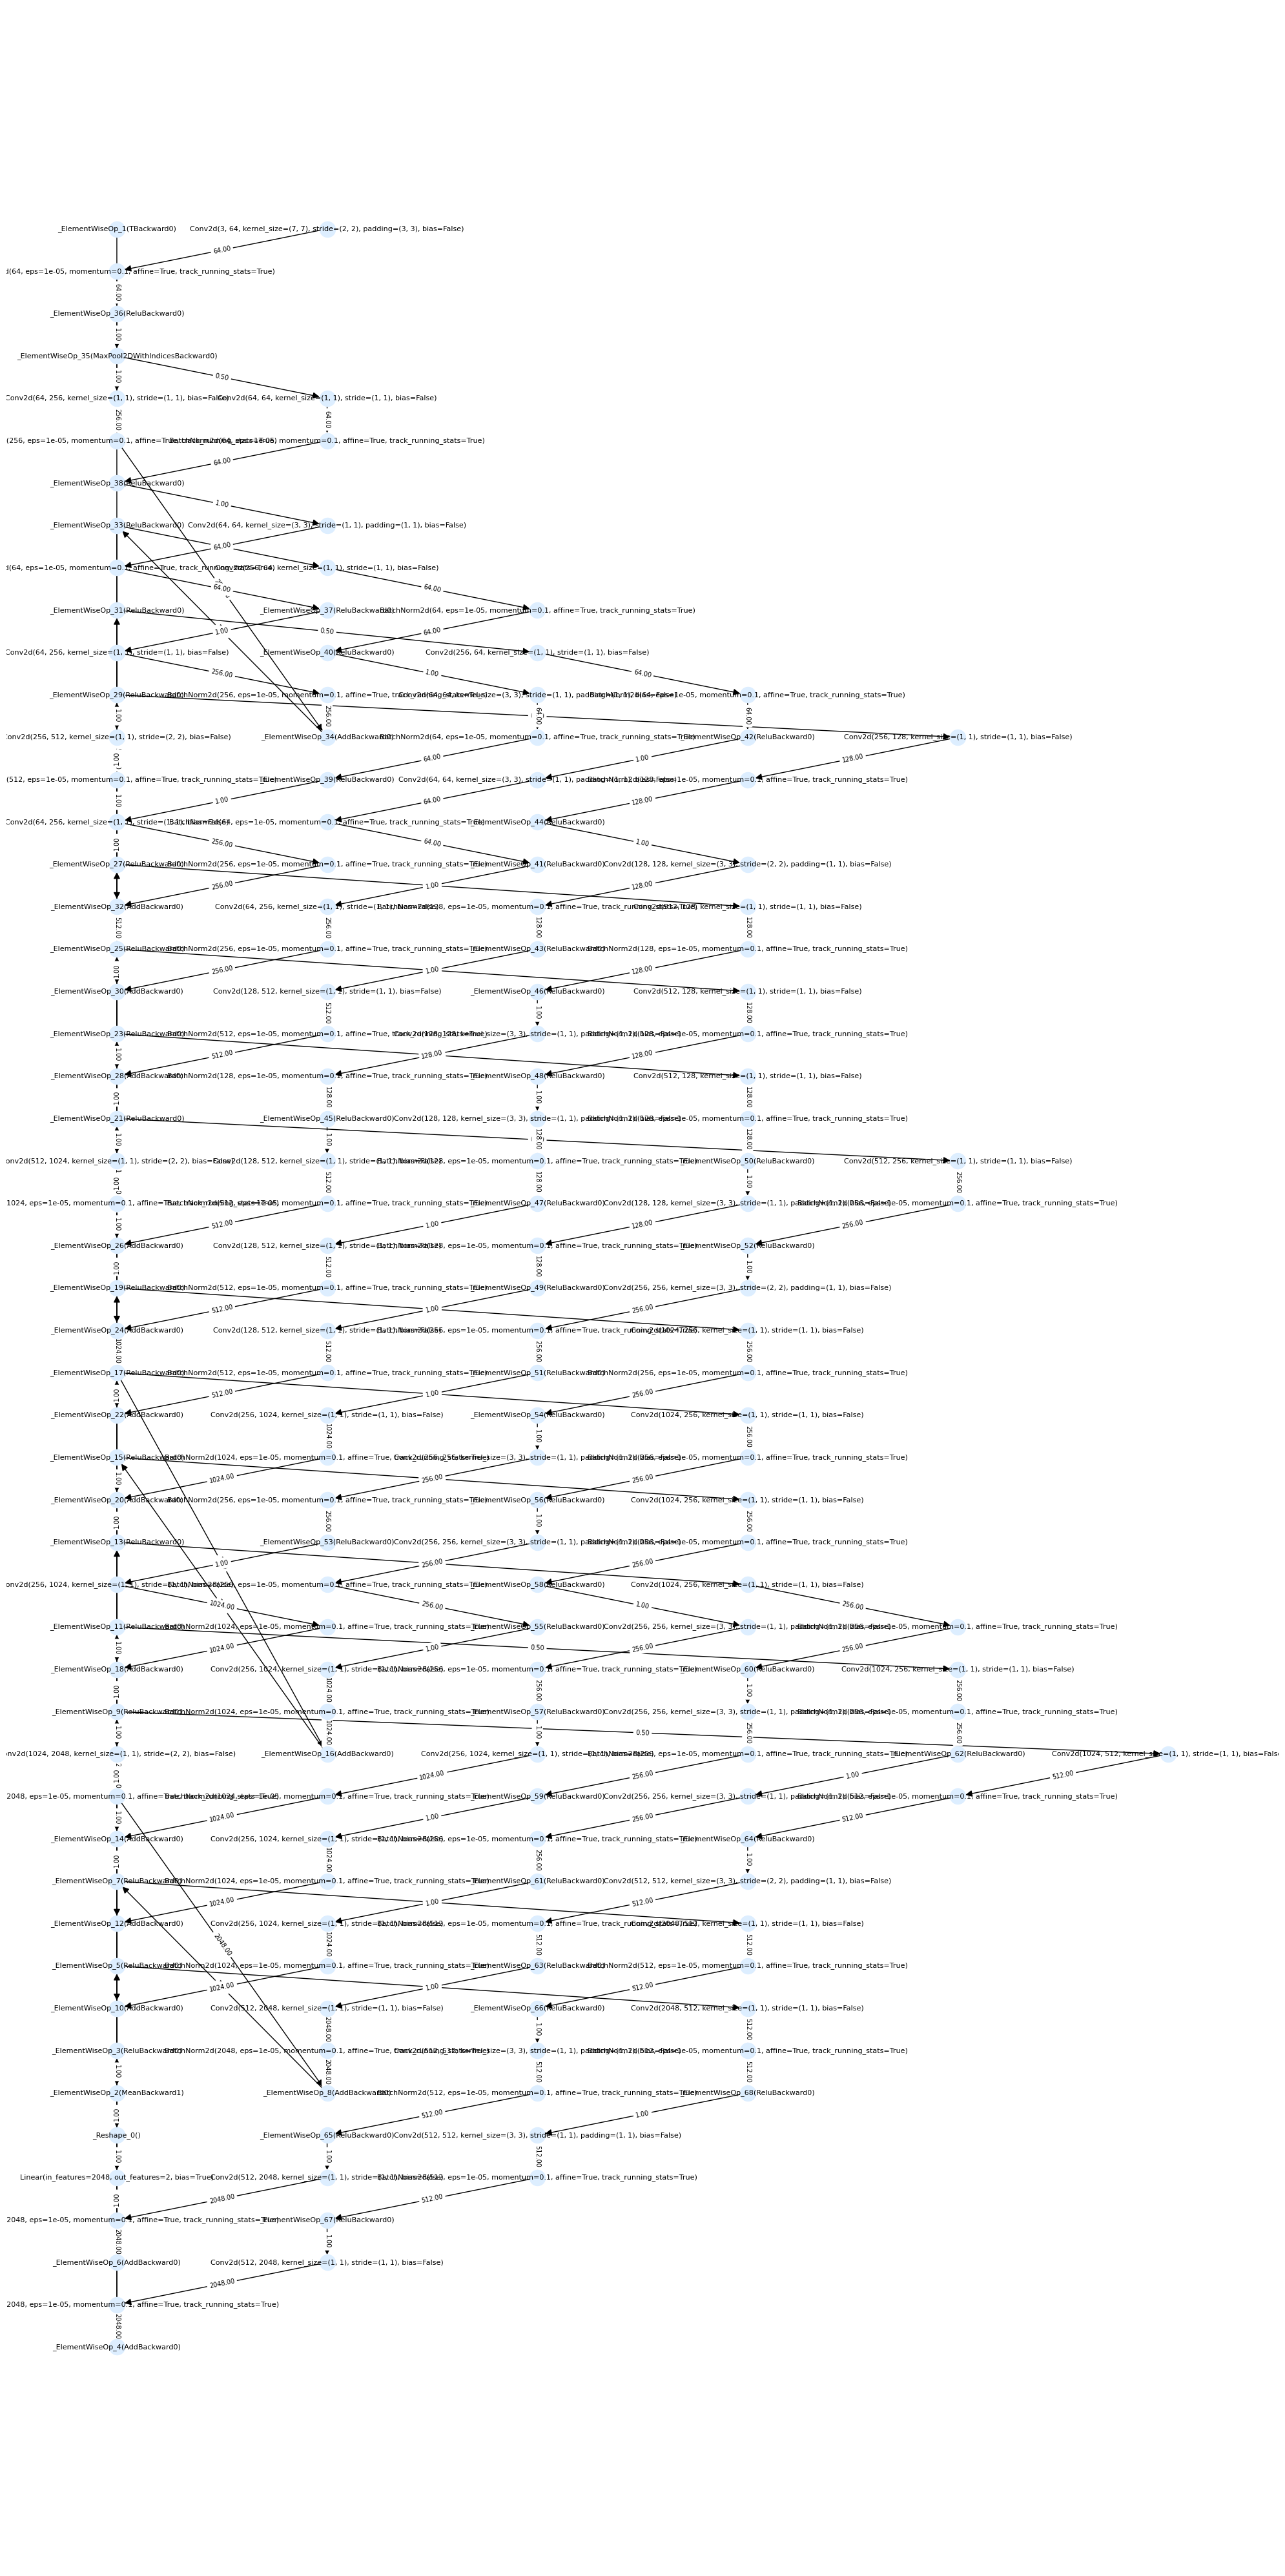

In [17]:
G = graphmodel_to_networkx(gm)
plot_graph(G, figsize=(20, 40), by_level=True)

Выполним forward pass.

In [18]:
out, flow = gm.forward_with_flow(example_inputs)

Покажем топ-10 рёбер по flow.

In [19]:
top = sorted(flow.items(), key=lambda kv: kv[1], reverse=True)[:10]
print("\nTop edges by estimated flow:")
for e, v in top:
    print(f" {repr(e)} : {v:.4f}")


Top edges by estimated flow:
 GraphEdge(Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) -> BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), gamma=256.0000) : 0.0937
 GraphEdge(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) -> BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), gamma=64.0000) : 0.0761
 GraphEdge(BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) -> _ElementWiseOp_34(AddBackward0), gamma=256.0000) : 0.0544
 GraphEdge(BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) -> _ElementWiseOp_30(AddBackward0), gamma=256.0000) : 0.0457
 GraphEdge(BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) -> _ElementWiseOp_32(AddBackward0), gamma=256.0000) : 0.0397
 GraphEdge(BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) -> _ElementWiseOp_34(AddBackward0), gam

Достанем группу для прунинга.

In [20]:
group = gm.get_pruning_group_for(model.layer1[0].conv1, pruning_fn=tp.prune_conv_out_channels, idxs=[0,1])
print(group)


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)) => prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)), len(idxs)=2
[1] prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)) => prune_out_channels on layer1.0.bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), len(idxs)=2
[2] prune_out_channels on layer1.0.bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) => prune_out_channels on _ElementWiseOp_38(ReluBackward0), len(idxs)=2
[3] prune_out_channels on _ElementWiseOp_38(ReluBackward0) => prune_in_channels on layer1.0.conv2 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)), len(idxs)=2
--------------------------------



### Оптимизация графовой модели

Инициализируем модель.

In [59]:
model = get_model(device='cuda')

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


  0%|          | 0/157 [00:00<?, ?it/s]

Создадим графовую модель.

In [60]:
example_inputs = torch.randn(1, 3, 224, 224).to('cuda')
gm = GraphModel(
    model,
    example_inputs,
    weight_init='by_params',
    normalize_by_level=True
    )

Создадим суррогатную модель.

In [61]:
class SurrogateModel(nn.Module):
    def __init__(self, num_edges):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_edges, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

Проведём оптимизацию.

In [81]:
surrogate_model, best_mask, min_flow_delta = optimize_graph(gm, example_inputs, SurrogateModel)

sample:   0%|          | 0/2000 [00:00<?, ?it/s]

Iter 0, pred=-0.0608, true=0.1989
Iter 200, pred=0.2076, true=0.2062
Iter 400, pred=0.2222, true=0.1835
Iter 600, pred=0.1609, true=0.1359
Iter 800, pred=0.1484, true=0.1804
Iter 1000, pred=0.1859, true=0.1587
Iter 1200, pred=0.1611, true=0.1779
Iter 1400, pred=0.2069, true=0.2625
Iter 1600, pred=0.1385, true=0.1502
Iter 1800, pred=0.1619, true=0.1619


In [87]:
print(f'Best flow delta: {min_flow_delta.item():.5f}')

Best flow delta: 0.07202
